In [ ]:
from google.colab import files
uploaded = files.upload()

Saving get_dataset.py to get_dataset.py
Saving models.py to models.py


In [ ]:
!python get_dataset.py

100% 620M/620M [00:29<00:00, 21.8MB/s]
Extracting files...
Copied all files to data


## Importing Packages

In [ ]:
!pip install pytorch-ignite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.2/343.2 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ignite.engine import Engine, Events
import ignite.distributed as idist

## Dataset and Dataloader Instantiation

In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self, image_folder):
        self.image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', 'png', '.bmp'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_bgr = cv2.imread(self.image_paths[idx])
        img_bgr = cv2.resize(img_bgr, (64, 64))
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB).astype(np.float32)

        L = img[:, :, 0] / 255

        ab = (img[:, :, 1:] - 128) / 128
        L = torch.from_numpy(L).unsqueeze(0).float()
        ab = torch.from_numpy(ab).permute(2,0,1).float()

        return L, ab

In [ ]:
from torch.utils.data import DataLoader, random_split

dataset = ColorizationDataset(image_folder = 'data')

total_size = len(dataset)
train_size = int(.7 * total_size)
test_size = total_size - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

train_loader = idist.auto_dataloader(train_data, batch_size = 32, shuffle = True, num_workers = 2, drop_last = True)
test_loader = idist.auto_dataloader(test_data, batch_size = 32, shuffle = True, num_workers = 2, drop_last = True)

2025-06-11 21:56:58,227 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<torch.utils.data.da': 
	{'batch_size': 32, 'shuffle': True, 'num_workers': 2, 'drop_last': True, 'pin_memory': True}
2025-06-11 21:56:58,228 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<torch.utils.data.da': 
	{'batch_size': 32, 'shuffle': True, 'num_workers': 2, 'drop_last': True, 'pin_memory': True}


## Dataset Visualization

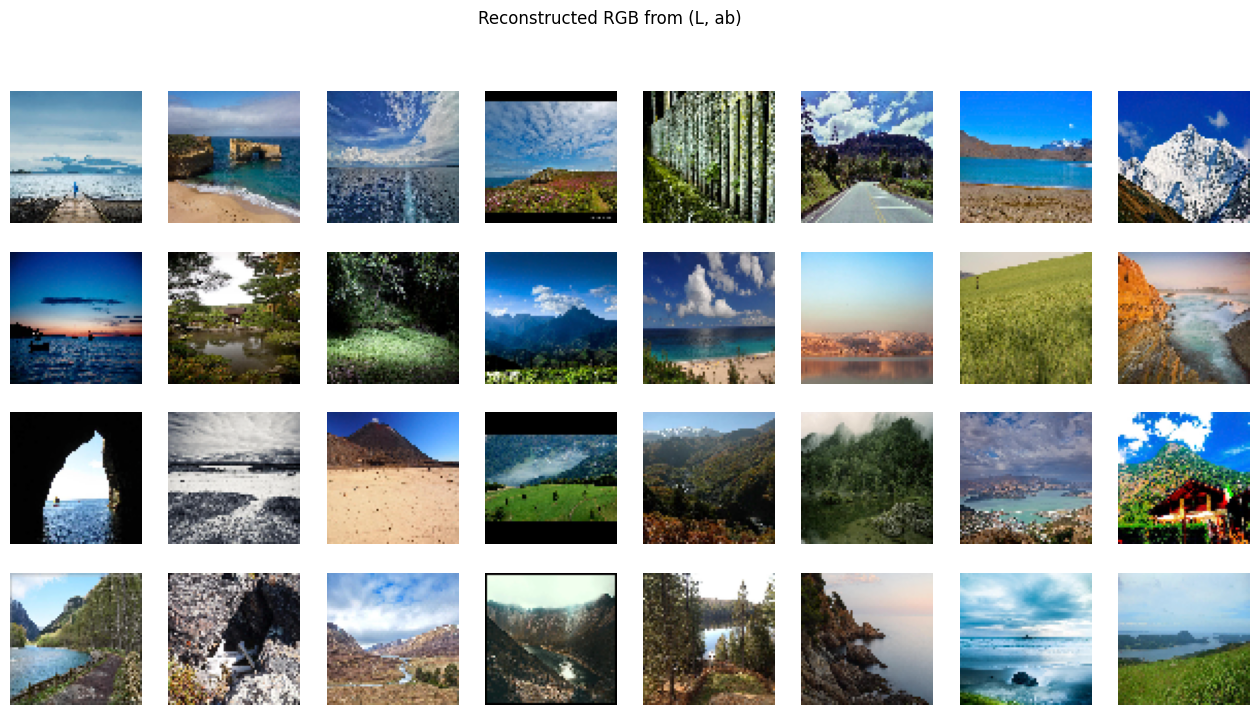

In [ ]:
L_batch, ab_batch = next(iter(train_loader))

def lab_to_rgb(L, ab):
    L = np.squeeze(L)
    ab = np.transpose(ab, (1,2,0)) if ab.ndim == 3 else ab
    L = L * 255
    ab = (ab * 128) + 128
    lab = np.concatenate([L[..., np.newaxis], ab], axis = 2).astype(np.uint8)
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return rgb


plt.figure(figsize = (16,8))
for i in range(32):
    L = L_batch[i].numpy()
    ab = ab_batch[i].numpy()
    rgb = lab_to_rgb(L, ab)

    plt.subplot(4,8,i+1)
    plt.imshow(rgb)
    plt.axis('off')

plt.suptitle("Reconstructed RGB from (L, ab)")
plt.show()

## Loading Models

In [ ]:
from models import UNet, PatchGAN
import torch.optim as optim
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
G = idist.auto_model(UNet(in_channels = 1, out_channels = 2))
D = idist.auto_model(PatchGAN(in_channels = 3))

## Defining Hyperparameters

In [ ]:
lr = 2e-4
num_epochs = 100
lambda_l1 = 100

opt_G = idist.auto_optim(optim.Adam(G.parameters(), lr = lr, betas = (0.5, 0.999)))
opt_D = idist.auto_optim(optim.Adam(D.parameters(), lr = lr, betas = (0.5, 0.999)))

criterion_GAN = nn.BCELoss()
criterion_L1 = nn.L1Loss()

## Training

In [ ]:
real_label = 1.0
fake_label = 0.0

def training_step(engine, batch):
    G.train()
    D.train()

    L, ab = batch
    L, ab = L.to(device), ab.to(device)
    b_size = L.size(0)

    opt_D.zero_grad()

    real = torch.cat([L, ab], dim = 1)
    fake_ab = G(L)
    fake = torch.cat([L, fake_ab.detach()], dim = 1)

    label_real = torch.full_like(D(real), real_label, dtype = torch.float)
    label_fake = torch.full_like(D(fake), fake_label, dtype = torch.float)

    pred_real = D(real)
    pred_fake = D(fake)

    loss_D_real = criterion_GAN(pred_real, label_real)
    loss_D_fake = criterion_GAN(pred_fake, label_fake)
    loss_D = 0.5 * (loss_D_real + loss_D_fake)

    loss_D.backward()
    opt_D.step()

    opt_G.zero_grad()
    pred_fake = D(torch.cat([L, fake_ab], dim = 1))
    label_G = torch.full_like(pred_fake, real_label, dtype = torch.float)


    loss_G_GAN = criterion_GAN(pred_fake, label_G)
    loss_G_L1 = criterion_L1(fake_ab, ab)
    loss_G = loss_G_GAN + lambda_l1 * loss_G_L1

    loss_G.backward()
    opt_G.step()

    return {
        'loss_G': loss_G.item(),
        'loss_D': loss_D.item()
    }

In [ ]:
trainer = Engine(training_step)

In [ ]:
G_losses = []
D_losses = []

@trainer.on(Events.EPOCH_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    G_losses.append(o['loss_G'])
    D_losses.append(o['loss_D'])

In [ ]:
from ignite.metrics import FID

fid_metric = FID(device = idist.device())

In [ ]:
import PIL.Image as Image

def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img.cpu())
        resized_img = pil_img.resize((299, 299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)

def evaluation_step(engine, batch):
    G.eval()
    with torch.no_grad():
        L, ab = batch
        L, ab = L.to(device), ab.to(device)

        fake_ab = G(L)
        fake_rgb_batch = []
        real_rgb_batch = []

        for i in range(L.size(0)):
            L_np = L[i].cpu().numpy().transpose(1, 2, 0)
            ab_real_np = ab[i].cpu().numpy()
            ab_fake_np = fake_ab[i].cpu().numpy()

            real_rgb = lab_to_rgb(L_np, ab_real_np)
            fake_rgb = lab_to_rgb(L_np, ab_fake_np)

            real_rgb_batch.append(transforms.ToTensor()(real_rgb))
            fake_rgb_batch.append(transforms.ToTensor()(fake_rgb))

        real_rgb_batch = interpolate(torch.stack(real_rgb_batch))
        fake_rgb_batch = interpolate(torch.stack(fake_rgb_batch))

        return fake_rgb_batch.to(device), real_rgb_batch.to(device)

In [ ]:
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, 'fid')

In [ ]:
fid_values = []

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(test_loader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    fid_values.append(fid_score)
    print(f"Epoch [{engine.state.epoch}/100] Metric Scores")
    print(f"*   FID : {fid_score:4f}")


In [ ]:
def training(*args):
    trainer.run(train_loader, max_epochs = 100)

In [ ]:
with idist.Parallel(backend = 'nccl') as parallel:
    parallel.run(training)

2025-06-11 21:57:01,819 ignite.distributed.launcher.Parallel INFO: Initialized processing group with backend: 'nccl'
2025-06-11 21:57:01,822 ignite.distributed.launcher.Parallel INFO: - Run '<function training at 0x7f0631084360>' in 1 processes


Epoch [1/100] Metric Scores
*   FID : 0.026250
Epoch [2/100] Metric Scores
*   FID : 0.014987
Epoch [3/100] Metric Scores
*   FID : 0.027110
Epoch [4/100] Metric Scores
*   FID : 0.023721
Epoch [5/100] Metric Scores
*   FID : 0.020517
Epoch [6/100] Metric Scores
*   FID : 0.013883
Epoch [7/100] Metric Scores
*   FID : 0.013969
Epoch [8/100] Metric Scores
*   FID : 0.009817
Epoch [9/100] Metric Scores
*   FID : 0.011388
Epoch [10/100] Metric Scores
*   FID : 0.010543
Epoch [11/100] Metric Scores
*   FID : 0.010447
Epoch [12/100] Metric Scores
*   FID : 0.011273
Epoch [13/100] Metric Scores
*   FID : 0.010828
Epoch [14/100] Metric Scores
*   FID : 0.011555
Epoch [15/100] Metric Scores
*   FID : 0.010147
Epoch [16/100] Metric Scores
*   FID : 0.010725
Epoch [17/100] Metric Scores
*   FID : 0.011036
Epoch [18/100] Metric Scores
*   FID : 0.011250
Epoch [19/100] Metric Scores
*   FID : 0.011697
Epoch [20/100] Metric Scores
*   FID : 0.010941
Epoch [21/100] Metric Scores
*   FID : 0.009934
E

2025-06-11 23:03:24,466 ignite.distributed.launcher.Parallel INFO: End of run
2025-06-11 23:03:24,468 ignite.distributed.launcher.Parallel INFO: Finalized processing group with backend: 'nccl'


Epoch [100/100] Metric Scores
*   FID : 0.008034


## Generative vs Discriminative Loss

Text(0.5, 1.0, 'Generative and Discriminative Loss over Training')

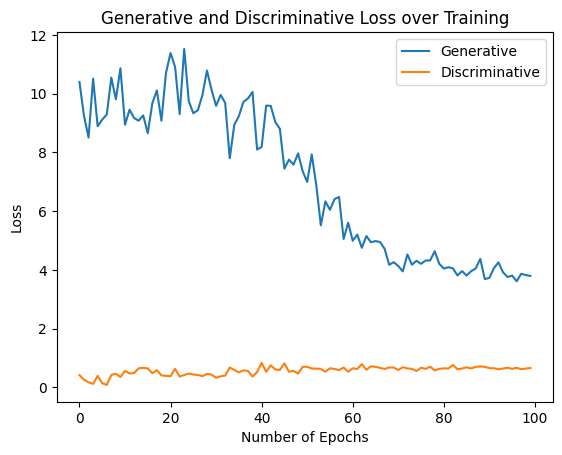

In [ ]:
plt.plot(G_losses, label = 'Generative')
plt.plot(D_losses, label = 'Discriminative')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Generative and Discriminative Loss over Training')

## Inference

In [ ]:
import torchvision.utils as vutils

G.eval()
L_batch, ab_batch = next(iter(test_loader))
L_batch = L_batch.to(device)
ab_batch = ab_batch.to(device)

def lab_to_rgb(L, ab):
    L = L.squeeze(0).cpu().numpy() * 100
    ab = ab.cpu().numpy() * 128
    lab = np.zeros((L.shape[0], L.shape[1], 3), dtype=np.float32)
    lab[:, :, 0] = L
    lab[:, :, 1:] = ab.transpose(1, 2, 0)
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return np.clip(rgb, 0, 1)

with torch.no_grad():
    ab_fake_batch = G(L_batch)

real_rgb_list = []
fake_rgb_list = []

for i in range(min(16, L_batch.size(0))):
    L = L_batch[i]
    ab_real = ab_batch[i]
    ab_fake = ab_fake_batch[i]

    real_rgb = lab_to_rgb(L, ab_real)
    fake_rgb = lab_to_rgb(L, ab_fake)

    real_rgb_list.append(torch.from_numpy(real_rgb.transpose(2, 0, 1)))
    fake_rgb_list.append(torch.from_numpy(fake_rgb.transpose(2, 0, 1)))


## FID

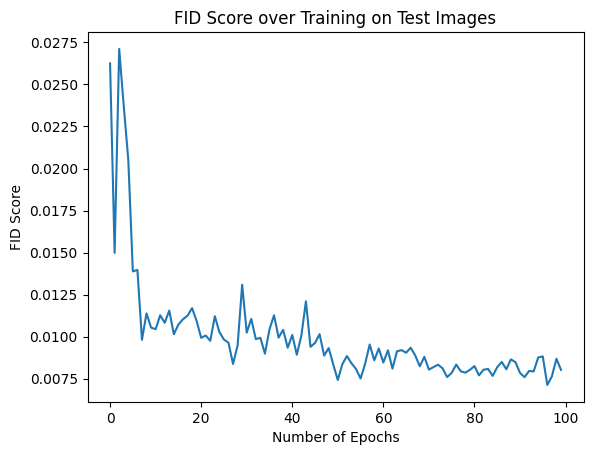

In [ ]:
plt.xlabel('Number of Epochs')
plt.ylabel('FID Score')
plt.title('FID Score over Training on Test Images')
plt.plot(fid_values)

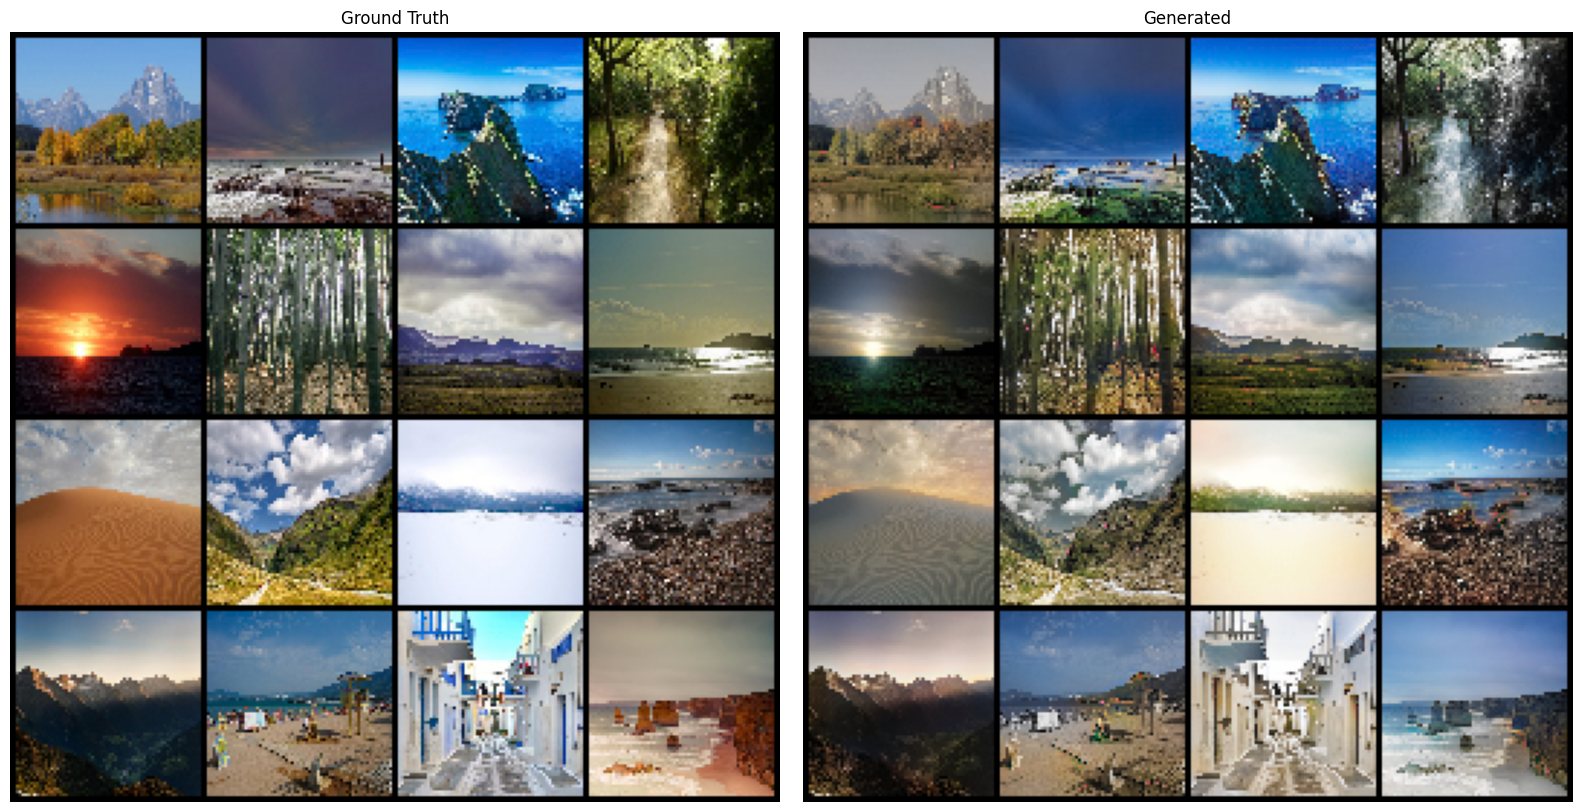

In [ ]:
real_grid = vutils.make_grid(real_rgb_list, nrow=4, padding=2)
fake_grid = vutils.make_grid(fake_rgb_list, nrow=4, padding=2)

plt.figure(figsize=(16, 8))


plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Ground Truth')
plt.imshow(np.transpose(real_grid.numpy(), (1, 2, 0)))


plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Generated')
plt.imshow(np.transpose(fake_grid.numpy(), (1, 2, 0)))

plt.tight_layout()
plt.show()